# PCA demonstration

### Outline
- Intro and motivation for PCA
- Dataset used. Reading and preprocessing the data
- Exploratory visualizations and rescaling
- Applying PCA. Using biplots to explore the transformed features. 
- An interactive visualization to compbine original features and principal components

## When can we use PCA? 

- We can discover latent features (that are linear combinations of the original features) by extracting the features with maximum variance.
- PCA is often used as a preprocessing step (dimensionality reduction) before supervised learning. It can drastically reduce the size of the feature space. This can be very useful especially when we have a lot of features but our data is not enough to "fill" the feature space.
- One potential negative of PCA is that the resultant components may be harder to interpret than the original features when models are fit on them. But on high-dimensionality datasets, this can actually provide meaning to data that may not have an obvious prior grouping.
- A reduced feature space can make it easier to visualize data that has a high dimensionality. In the example below we use PCA as an exploratory technique.

We will use data from Gapminder that contains socio-economic and educational info about many countries around the world. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import decomposition, preprocessing

# plotting settings
%matplotlib inline
sns.set_context('notebook', font_scale=1.3)

# for high resolution displays
%config InlineBackend.figure_format = 'retina'

# for interactive plotting with hover
import mpld3
from mpld3 import plugins

# helper functions for the demonstration
import utilities as utils

%load_ext autoreload
%load_ext watermark

%autoreload 2

### Package versions

In [34]:
%watermark -d -v -p numpy,matplotlib,pandas,seaborn,mpld3,scikit-learn

2016-09-19 

CPython 3.5.1
IPython 4.2.0

numpy 1.11.0
matplotlib 1.5.1
pandas 0.18.1
seaborn 0.7.1
mpld3 0.2
scikit-learn 0.17.1


# Read and preprocess data

We combine several features:
- primary school completion rates for *male* and *female* students. It is calculated by taking the total number of female/male students in the last grade of primary school, minus the number of repeaters in that grade, divided by the total number of male/female children of official graduation age. 
- income per person - Gross Domestic Product per capita (fixed 2011 international dollars).
- employment over the age of 15 (as a percentage of the total population for that year). 
- life expectancy at birth

All of these are taken for the year 2006. 

In [2]:
from os.path import join as pjoin

# data obtained from www.gapminder.org/data/
filenames = ["completion_male.csv", "completion_female.csv", "income_per_person.csv",
             "employment_over_15.csv", "life_expectancy.csv"]

gapminder_data = []
for name in filenames: 
    table = pd.read_csv(pjoin('gapminder_data', name), index_col="country")
    gapminder_data.append(table)
    
# create a dataframe with multiple features per country
df = pd.concat(gapminder_data, join="inner", axis=1)
df.head()

/Users/nikolay_shenkov/anaconda/envs/data_analysis/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/nikolay_shenkov/anaconda/envs/data_analysis/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,completion_male,completion_female,income_per_person,employment,life_expectancy
country,,,,,
Afghanistan,NaN,NaN,1193.282161,56.000000,53.2
Albania,NaN,NaN,8090.423280,51.400002,74.5
Algeria,NaN,NaN,12088.087622,50.000000,74.8
Angola,NaN,NaN,5303.703307,75.500000,56.9
Argentina,97.91143,102.10666,12912.711243,58.400002,75.5


In [3]:
df.shape

(169, 5)

We will keep only countries for which we have a complete set of features (no missing data in any of the columns). Note that this **introduces a bias** - the missing data is not 'missing at random'. Poorer countries tend to have more missing data. So we are likely removing countries that have problems with their completion rates.

In [4]:
df.dropna(axis=0, how="any", inplace=True)

### Income per person transformation

Before we apply PCA, it is a good idea to check the distributions of the original features. Features with extreme values, or with highly skewed distributions might inversely affect PCA performance.

In our case income per person is highly skewed.

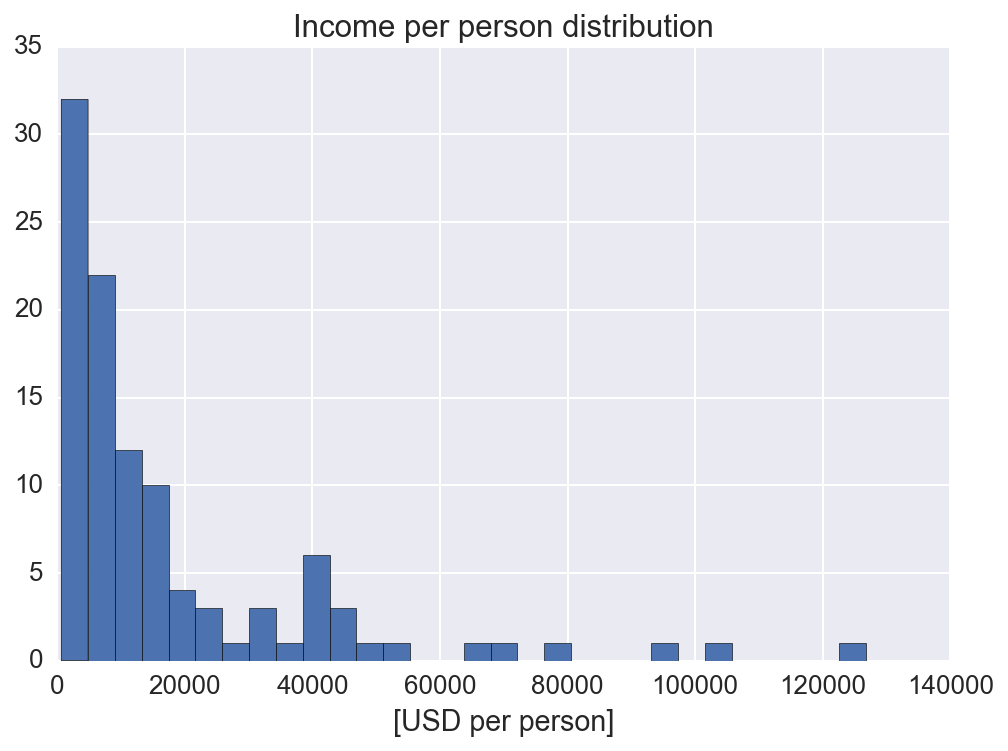

In [5]:
df.income_per_person.hist(bins=30)
plt.title('Income per person distribution');
plt.xlabel('[USD per person]')

It is common to apply a log transform to this type of variable to reduce the skewness.

In [6]:
# take the log of income_per_person 
# - this variable follows approximately a log-normal distribution
df['log_income'] = np.log(df['income_per_person'])

# for convenience, we drop the original feature
df.drop('income_per_person', axis=1, inplace=True)
df.head()

,completion_male,completion_female,employment,life_expectancy,log_income
country,,,,,
Argentina,97.91143,102.10666,58.400002,75.5,9.465967
Armenia,91.53127,94.58897,39.400002,72.2,8.749288
Austria,100.63802,101.12819,57.099998,80.0,10.656714
Azerbaijan,91.68856,90.66259,59.299999,69.9,9.264091
Bahamas,99.76959,96.84352,66.900002,72.1,10.133238


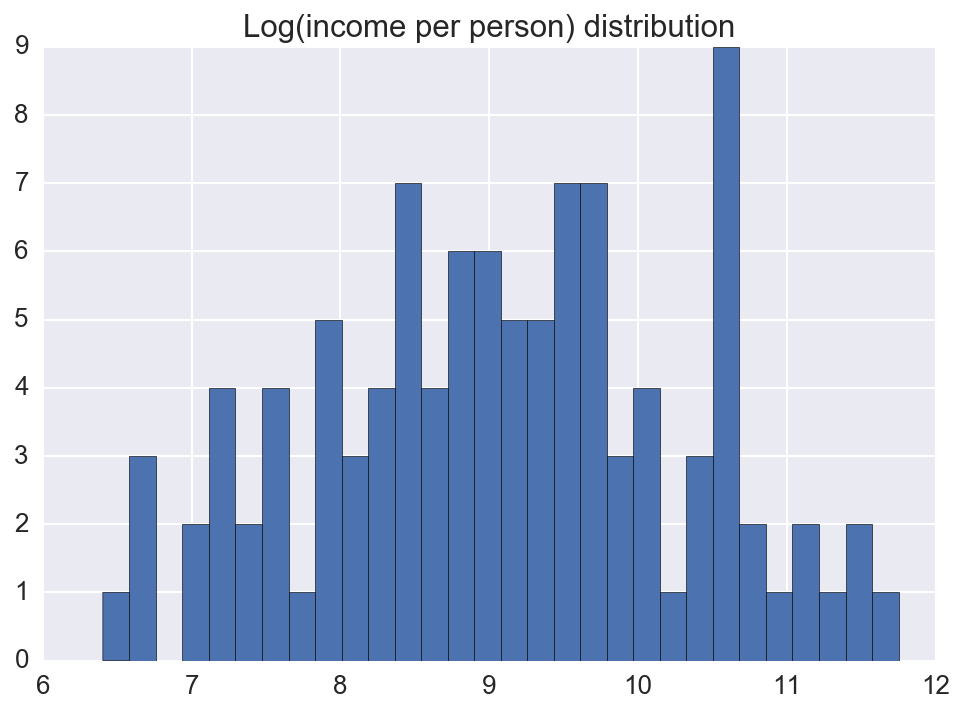

In [7]:
df.log_income.hist(bins=30)
plt.title('Log(income per person) distribution');

In [8]:
df.shape

(105, 5)

### Relationship between log_income and life_expectancy

We can quickly use regplot to check the relationship between log_income and life_expectancy. We expect that these two variables are correlated.

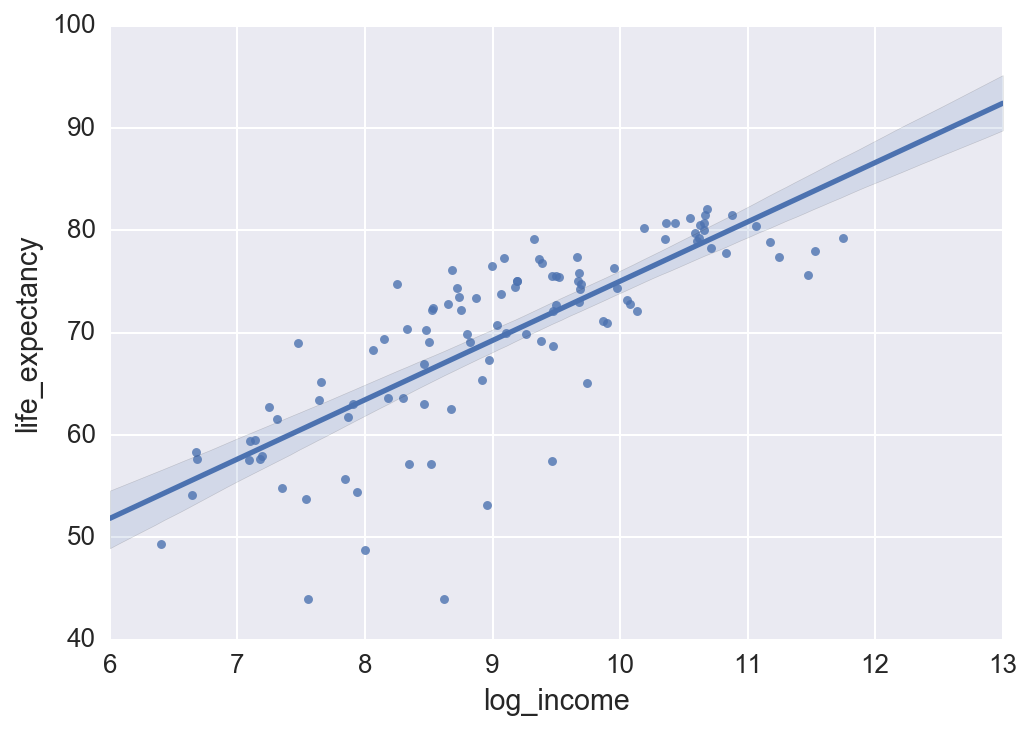

In [9]:
sns.regplot(data=df, x='log_income', y='life_expectancy')

While the relationship is roughly linear, note the presence of large number of outliers, especially for small log_income.

If we have many variables that are correlated with each other, we can use PCA to reduce the dimensionality by extracting only the essential information from each variable. 

# Perform PCA

In this section we perform PCA using the `sklearn` module. 

We first scale the data so that it has a mean = 0 and standard deviation = 1. This is done because our original features have very different ranges (e.g. life-expectancy is between 44 and 82, and log_income is between 6.4 and 11). Later we see what the effects are when we skip this rescaling step. 

In [10]:
# we need to scale data with mean = 0 and stdev = 1
scaled_data = preprocessing.scale(df)

In [11]:
# we will use PCA for exploratory visualizations - we keep 2 components only
pca = decomposition.PCA(n_components=2)

pca.fit(scaled_data)
transformed = pca.transform(scaled_data)

# let's take a look at the first ten rows of the transformed data
print(transformed[:10, :])

[[-1.03975554  0.23058621]
 [-0.67166986 -1.75975392]
 [-1.80668446  0.46156378]
 [-0.21292093  0.13139593]
 [-0.85548708  1.05467569]
 [-0.56685139  1.01592655]
 [-0.51592526 -0.39585543]
 [-1.38476499 -0.376583  ]
 [-0.48263095 -0.06380433]
 [ 1.20094548 -0.04428261]]


Each row represents a country, and the values are the scores of that country along the particular component (PC1 or PC2 in our case).

## Principal components

We can study the relationship between the original features and the components.

In [12]:
utils.components_table(pca, df)

,completion_male,completion_female,employment,life_expectancy,log_income
PC1,-0.502837,-0.508865,0.226403,-0.466181,-0.468644
PC2,-0.017325,-0.018845,0.936710,0.260947,0.232003


For example, PC1 places positive weight (0.23) on employment and negative weight on all the other features.
PC2 is dominated by employment and contains essentially no information about completion rates.

If we perform PCA on the unscaled data (the original df), the third feature (income_per_person) receives very little weight because its raw variance is much smaller than that of the rest of the features. 

In [13]:
pca_unscaled = decomposition.PCA(n_components=2, whiten=False)
pca_unscaled.fit(df)
utils.components_table(pca_unscaled, df)

,completion_male,completion_female,employment,life_expectancy,log_income
PC1,-0.616577,-0.743552,0.129118,-0.222275,-0.029738
PC2,-0.080651,-0.073170,-0.988500,-0.104575,-0.008602


## Exploring PC properties

#### Components are orthogonal to each other (dot product = 0)

In [14]:
np.dot(pca.components_[0], pca.components_[1])

0.0

#### Components are normaled to have length 1. 

In [15]:
(pca.components_.T**2).sum(axis=0)

array([ 1.,  1.])

#### The first two components together account for 84% of the variance in the data. 

In [16]:
pca.explained_variance_ratio_

array([ 0.66304229,  0.18088559])

## Biplot visualizations

A biplot is a scatterplot where each data point (country) is represented by its scores along the principal components. The axes are the principal components. In addition, the biplot shows the projection of the original features along the components. 

A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and the original features. 

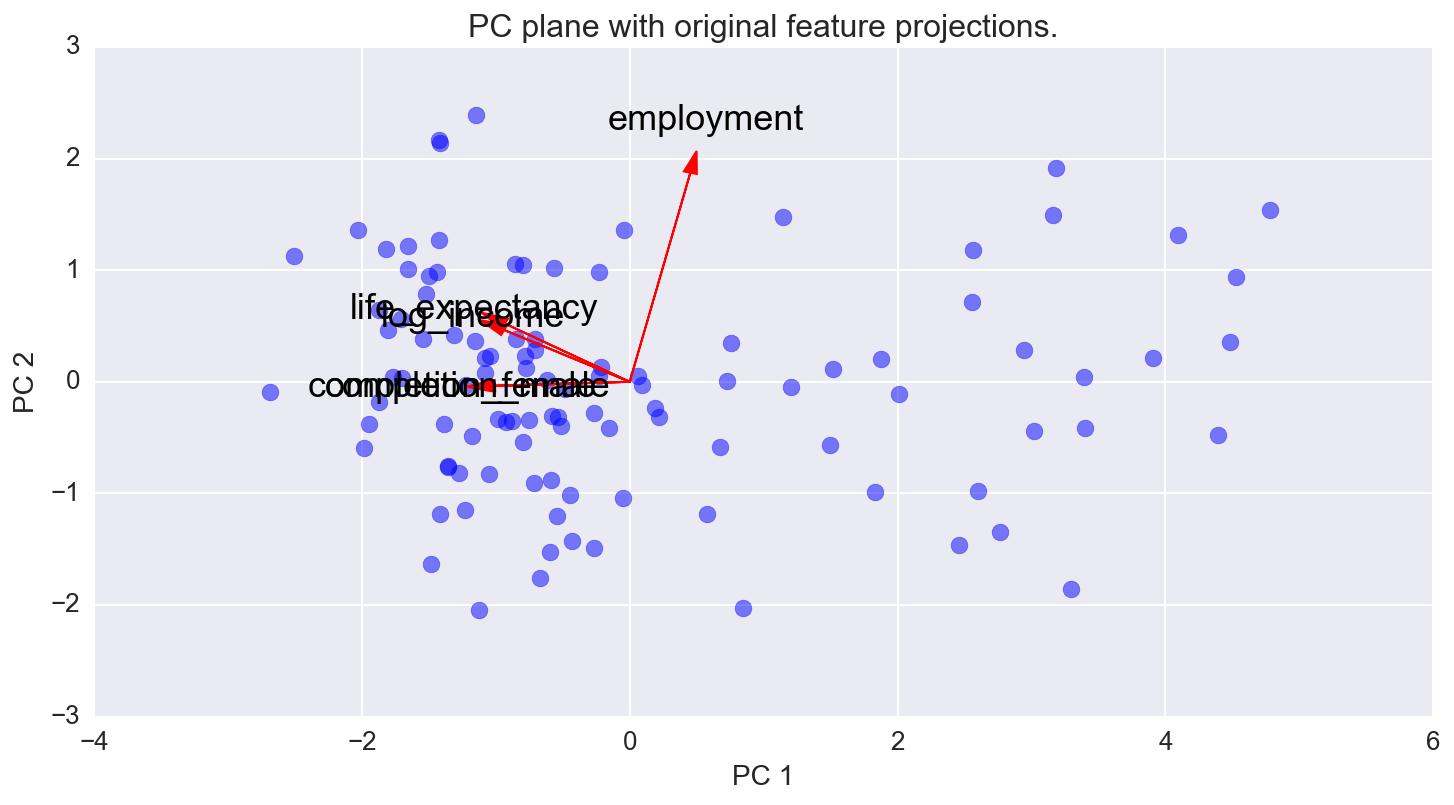

In [17]:
utils.biplot(df, transformed, pca)

### Observations:
- There are pairs of correlated variables: the completion rates, as well as life_expectancy and log_income. 
- Interestingly, the employment variable is largely uncorrelated with the rest.
- PC2 largely represents the employment variable. 
- PC1 is a linear combination of the rest of the variables

It is now easy to interpret the relateve positoin of a given point. For instance, a point in the top right corner will have a large employment percentage, but low completion rates. 

# Difference in (male - female) completion rates
Because the two completion rates are strongly correlated, we will construct a new feature (the difference male - female) and explore its relationship with the rest of the variables.

In [18]:
# Let's take a look at the difference in completion rates: 
df_diff = df[["log_income", "employment", "life_expectancy"]].copy()
df_diff["diff_completion"] = df.completion_male - df.completion_female

In [19]:
pca_diff = decomposition.PCA(n_components=2)
scaled_diff = preprocessing.scale(df_diff)

pca_diff.fit(scaled_diff)
transformed_diff = pca_diff.transform(scaled_diff)

print(transformed_diff[:5, :])

[[-0.90597675  0.19996421]
 [-0.80896797 -1.78711098]
 [-1.61095973  0.46755818]
 [-0.10251782  0.13118676]
 [-0.34930845  1.08249442]]


In [22]:
utils.components_table(pca_diff, df_diff)

,log_income,employment,life_expectancy,diff_completion
PC1,-0.613868,0.287496,-0.593018,0.434560
PC2,0.229222,0.933890,0.265717,0.068568


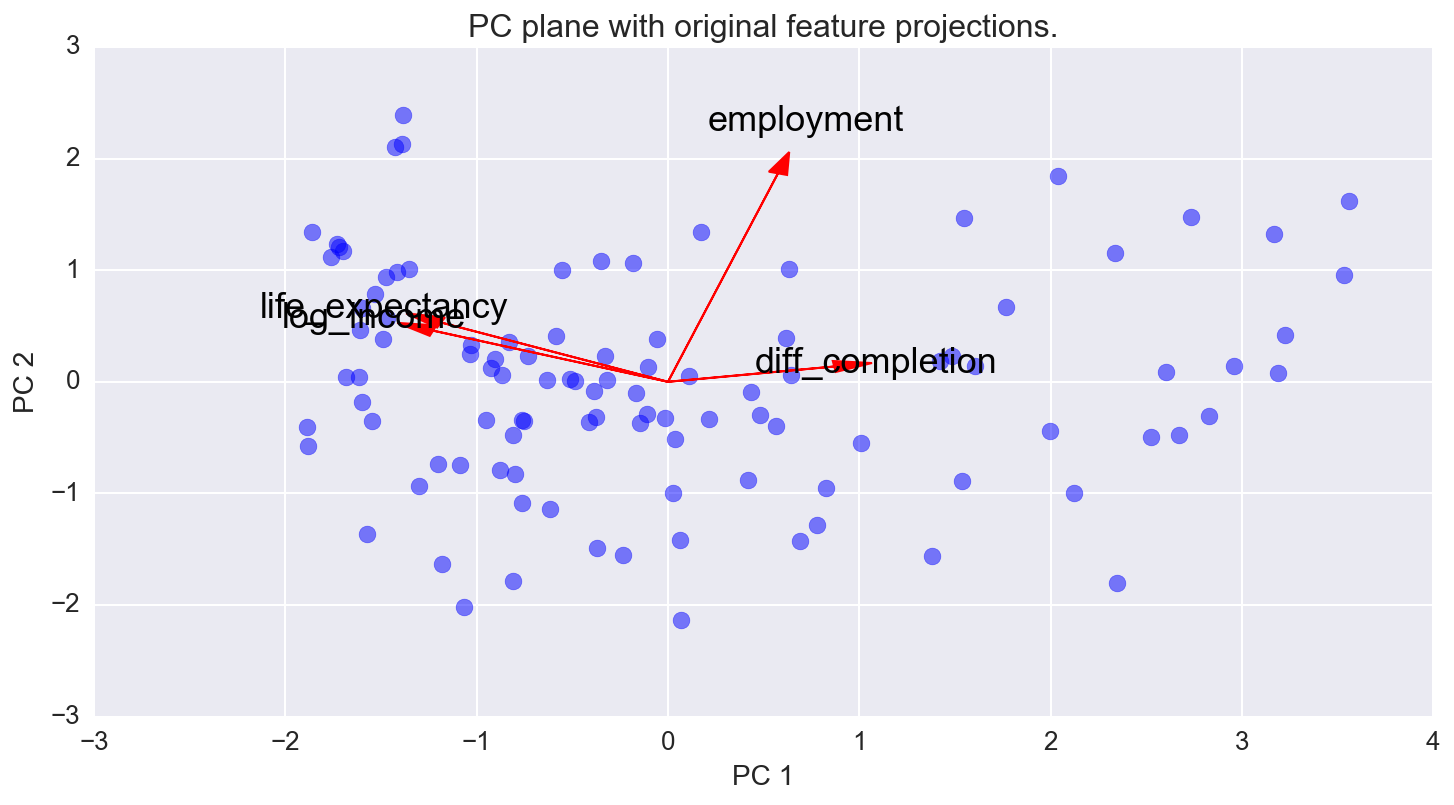

In [23]:
utils.biplot(df_diff, transformed_diff, pca_diff)

The new diff_completion variable behaves very differently - it is inversely correlated with life_expectancy and log_income - we can see that its projection points in the oppositve direction from the other two features.

This means that poor countries tend to have a larger gender inequality (in favour of male completion rates). 

Remember that our dataset only captures 105 countries, and many poor countries are not included. 

## Interactive visualization

Finally we will produce an interactive visualization that will allow us to explore the PCs together with the original features.

In [24]:
# we create a dataframe out of the transformed_diff data
df_transform = pd.DataFrame(index=df.index, data=transformed_diff, columns=["PC1", "PC2"])

# merge dataframes based on index - "country"
# we now have a dataframe that contains both the components and the original features
df_transform = df_transform.join(df_diff, how='inner')

We will use the mpld3 library for the visualization. Hover over a data point (country) to learn more about it. 

In [25]:
# Example with modifications from:
# http://mpld3.github.io/examples/html_tooltips.html

# Define some CSS to control our custom labels

css = """
table
{
  border-collapse: collapse;
}
th
{
  color: #ffffff;
  background-color: #000000;
}
td
{
  background-color: #cccccc;
}
table, th, td
{
  font-family:Arial, Helvetica, sans-serif;
  border: 1px solid black;
  text-align: right;
}
"""

fig, ax = plt.subplots(figsize=(10, 6))

# labels for the tooltips
labels = []
for i in range(len(df_transform)):
    label = df_transform.ix[[i], :].T
    label.columns = [df_transform.index[i]]
    # .to_html() is unicode; so make leading 'u' go away with str()
    labels.append(str(label.to_html()))

# scatter plot
points = ax.plot(df_transform.PC1, df_transform.PC2, 'o', color='b',
                 mec='k', ms=15, mew=1, alpha=.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Interactive projection on PC plane', size=20)

# add tooltips
tooltip = plugins.PointHTMLTooltip(points[0], labels,
                                   voffset=10, hoffset=10, css=css)
plugins.connect(fig, tooltip)

mpld3.display()